## Libraries

In [1]:
import gymnasium as gym
import numpy as np
from statistics import mean, stdev
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random
import math
import tensorflow as tf

In [2]:
# Implementacion de semilla para reproducibilidad del experimento
SEED=42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
EVAL_SEEDS = [20000, 20001, 20002, 20003, 20004]

## Class ReplayMemory

Memory of transitions for experience replay.

In [3]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal_states = self.terminal_states[batch]
        return states, actions, rewards, states_next, terminal_states

In [4]:
import time

def evaluar_agente_entrenado(agent, environment, eval_base_seeds, episodes_per_run=100, visualizar=False):
    """
    Evalúa un agente entrenado tras finalizar su entrenamiento y muestra resultados por consola.
    
    Args:
        agent: Agente entrenado, debe implementar .select_greedy_policy().
        environment: Entorno Gym ya inicializado.
        eval_base_seeds: Lista de semillas base para cada run.
        episodes_per_run: Número de episodios por run.
        visualizar: Si True, renderiza el entorno.

    Returns:
        None (imprime resultados por consola).
    """

    agent_name = getattr(agent, 'name', f"Agente_{id(agent)}")
    print(f"\n===== Evaluación del Agente: {agent_name} =====")
    
    resultados_runs = []

    for run_idx, base_seed in enumerate(eval_base_seeds):
        print(f"\n--- Run {run_idx + 1}/{len(eval_base_seeds)} | Semilla base: {base_seed} ---")

        if hasattr(agent, 'delete_scores'):
            agent.delete_scores()

        episodios_scores = []
        inicio_run = time.perf_counter()

        for ep_idx in range(episodes_per_run):
            semilla_ep = base_seed + ep_idx
            state, _ = environment.reset(seed=semilla_ep)

            score = 0.0
            terminated = truncated = False

            while not (terminated or truncated):
                action = agent.select_greedy_policy(state)
                if visualizar:
                    environment.render()
                state, reward, terminated, truncated, _ = environment.step(action)
                score += reward

            episodios_scores.append(score)

            if hasattr(agent, 'add_score'):
                agent.add_score(score)

        tiempo_run = round((time.perf_counter() - inicio_run) / 60, 2)
        media_run = np.mean(episodios_scores)
        max_run = np.max(episodios_scores)
        min_run = np.min(episodios_scores)
        std_run = np.std(episodios_scores)

        print(f"Run {run_idx + 1}: Promedio={media_run:.2f}, Max={max_run:.2f}, Min={min_run:.2f}, StdDev={std_run:.2f}, Tiempo={tiempo_run} min")

        resultados_runs.append(media_run)

    # Estadísticas globales
    media_global = np.mean(resultados_runs)
    std_global = np.std(resultados_runs)
    print(f"\n--- Resumen Global para {agent_name} ---")
    print(f"Promedio de puntuaciones promedio entre runs: {media_global:.2f}")
    print(f"Desviación estándar entre runs: {std_global:.2f}")


## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [5]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions, modelo,use_target_network=False):
        # Initialize variables and create neural model
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.use_target_network = use_target_network
        # Neural model
        self.model = modelo
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
        # Target model
        self.target_model = keras.models.clone_model(self.model)
        self.target_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
        self.target_model.set_weights(self.model.get_weights())
    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state, exploration_rate):
        """Si el numero generado [0,1] es menor que la tasa de exploración, el agente explorará el entorno tomando una acción aleatoria. Si no, seleccionará la mejor acción de la tabla qvalues (q-table) para el estado actual."""
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model(state).numpy()
            return np.argmax(q_values[0])

    def select_greedy_policy(self, state):
        # Generate an action for a given state using greedy policy
        state = np.reshape(state, [1, self.number_of_observations])
        q_values = self.model(state).numpy()
        return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model(states).numpy()
        if self.use_target_network:
            q_next_states = self.target_model(next_states).numpy()
        else:
            q_next_states = self.model(next_states).numpy()

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])

        self.model.train_on_batch(states, q_targets)

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def soft_update_target_network(self, tau=0.005):
        model_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        new_weights = []

        for model_w, target_w in zip(model_weights, target_weights):
            updated_w = tau * model_w + (1.0 - tau) * target_w
            new_weights.append(updated_w)

        self.target_model.set_weights(new_weights)



    def add_score(self, score):
        # Add the obtained score to a list to be presented later
        self.scores.append(score)

    def delete_scores(self):
        # Delete the scores
        self.scores = []

    def average_score(self, number_of_episodes):
        # Compute average score of the last episodes
        index = len(agent.scores) - number_of_episodes
        return np.mean(self.scores[max(0,index):(len(agent.scores))])

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")

## Entrono de entrenamiento

In [6]:
def create_environment():
    # Create simulated environment
    environment = gym.make("LunarLander-v3",render_mode=None)
    number_of_observations = environment.observation_space.shape[0]     # El estado es un vector de 8 valores
    number_of_actions = environment.action_space.n                      # 4 acciones
    return environment, number_of_observations, number_of_actions

## Program for training




#### Arquitecturas

In [7]:
environment, number_of_observations, number_of_actions = create_environment()

In [8]:
modelos = []

modelo1 = keras.Sequential([
        keras.layers.Dense(128, input_dim=number_of_observations, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(number_of_actions, activation='linear')
        ])
modelo2 = keras.Sequential([
        keras.layers.Dense(64, input_dim=number_of_observations, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(number_of_actions, activation='linear')
        ])
modelo3 = keras.Sequential([
        keras.layers.Dense(32, input_dim=number_of_observations, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(number_of_actions, activation='linear')
        ])
modelos.append(modelo1)
modelos.append(modelo2)
modelos.append(modelo3)

/opt/homebrew/Caskroom/miniforge/base/envs/tfg/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Entrenamiento de modelos

- Número de épocas: Se ha podido comprobar empíricamente que a partir  

In [9]:
resultados = []
tiempos_entrenamiento = []
agentes_entrenados = []

for modelo in modelos:
	LEARNING_RATE = 0.001
	BATCH_SIZE = 64
	GAMMA = 0.99 	# Discount factor gamma
	MEMORY_SIZE = 1000000 	# Size of the replay memory (replay buffer) that saves transitions (modificado, original 100000)
	EXPLORATION_RATE_MAX = 1 	# Values related to the exploration rate used by the epsilon-greedy policy
	EXPLORATION_RATE_MIN = 0.01
	EXPLORATION_RATE_DECAY = 0.99
	MAX_EPISODES_FOR_TRAINING = 1000		# Maximum number of episodes for training (reduccion tiempo de entrenamiento)
	TRAINING_GOAL = 230					# Goal score to be achieved during the training process (400 cambiado a 250)
	EPISODES_TO_CHECK_TRAINING_GOAL = 100		# Number of episodes used to check the goal score during the training process
	EPISODES_TO_EVALUATE_MODEL_PERFORMANCE = 100			# Number of episodes used to evaluate the model performance after training

	agent = DQN(number_of_observations, number_of_actions, modelo,False)
	episode = 0
	start_time = time.perf_counter()
	total_steps = 1
	exploration_rate = EXPLORATION_RATE_MAX
	goal_reached = False

	episodios = []
	scores = []
	while (episode < MAX_EPISODES_FOR_TRAINING) and not(goal_reached):      # Bucle de entrenamiento
		episode += 1
		score = 0
		state, info = environment.reset(seed=SEED+ episode)
		end_episode = False
		while not(end_episode):
			# Select an action for the current state
			action = agent.select(state, exploration_rate)

			# Execute the action on the environment
			state_next, reward, terminal_state, truncated, info = environment.step(action)  # Se avanza en el problema con la acción elegida, y step devuelve el proximo estado, recompensa, si ha acabado el episodio

			# Store in memory the transition (s,a,r,s')
			agent.remember(state, action, reward, state_next, terminal_state)   # Actualizar q-table con el nuevo estado y recompensa obtenidos

			score += reward # Se actualiza el score del episodio

			# Learn using a batch of experience stored in memory
			agent.learn()

			# Detectar si se ha finalizado el episodio
			if terminal_state or truncated:
				end_episode = True
				agent.add_score(score)
				average_score = agent.average_score(EPISODES_TO_CHECK_TRAINING_GOAL)
				if average_score >= TRAINING_GOAL: goal_reached = True
				print("Episode {0:>3}: ".format(episode), end = '')
				print("score {0:>3} ".format(math.trunc(score)), end = '')
				print("(exploration rate: %.3f, " % exploration_rate, end = '')
				print("average score: {0:>3}, ".format(round(average_score)), end = '')
				print("transitions: " + str(agent.memory.current_size) + ")")
				episodios.append(episode)
				scores.append(score)

			else:
				state = state_next
				total_steps += 1

		# Disminuir la tasa de exploración para comenzar con alta exploración, y se irá convergiendo hacia una solución enfocándose progresivamente en la explotación
		exploration_rate *= EXPLORATION_RATE_DECAY
		exploration_rate = max(EXPLORATION_RATE_MIN, exploration_rate)

	print("Time for training:", round((time.perf_counter() - start_time)/60), "minutes")
	print("Score (average last episode):", round(average_score))
	print("Score (max):", round(max(agent.scores)))
	evaluar_agente_entrenado(agent, environment, EVAL_SEEDS, episodes_per_run=100)

	# agent.display_scores_graphically()
	resultados.append((episodios, scores))
	training_time = (time.perf_counter() - start_time) # Tiempo en minutos
	tiempos_entrenamiento.append(training_time)
	agentes_entrenados.append(agent)


Episode   1: score -197 (exploration rate: 1.000, average score: -198, transitions: 81)
Episode   2: score -167 (exploration rate: 0.990, average score: -182, transitions: 193)
Episode   3: score -121 (exploration rate: 0.980, average score: -162, transitions: 274)
Episode   4: score -66 (exploration rate: 0.970, average score: -138, transitions: 341)
Episode   5: score -156 (exploration rate: 0.961, average score: -142, transitions: 473)
Episode   6: score -263 (exploration rate: 0.951, average score: -162, transitions: 550)
Episode   7: score -196 (exploration rate: 0.941, average score: -167, transitions: 662)
Episode   8: score -111 (exploration rate: 0.932, average score: -160, transitions: 726)
Episode   9: score -337 (exploration rate: 0.923, average score: -180, transitions: 839)
Episode  10: score -71 (exploration rate: 0.914, average score: -169, transitions: 905)
Episode  11: score -376 (exploration rate: 0.904, average score: -188, transitions: 1028)
Episode  12: score -272

In [10]:
def resultados_finales():
    for i, (episodios, scores) in enumerate(resultados):
        plt.figure(figsize=(10, 6))  # Crea una nueva figura para cada modelo
        plt.plot(episodios, scores, label=f'Score del Modelo {i + 1}')
        plt.xlabel('Episodios')
        plt.ylabel('Score')
        plt.title(f'Evolución del score para el Modelo {i + 1}') # Título específico del modelo
        plt.legend() # Añade la leyenda para claridad, aunque solo haya una línea
        plt.grid(True)
        plt.show() # Muestra la figura actual y la cierra para la siguiente iteración
    # Print training times using resultados
    print("\nTraining times for each model:")
    for i, training_time in enumerate(tiempos_entrenamiento):
        print(f"Model {i + 1}: {round(training_time/60, 2)} minutes")
    # Print average scores for each model
    print("\nAverage scores for each model:")
    for i, (episodes, scores) in enumerate(resultados):
        average_score = np.mean(scores)
        print(f"Model {i + 1}: {round(average_score, 2)}")

# Experimentación con redes Target

En esta sección se evalúa si el entrenamiento del agente mejora mediante la implementación de redes Target. Esta técnica se utiliza en el algoritmo DQN Learning para estabilizar el entrenamiento.

Se ha empleado la misma arquitectura de la sección anterior, con el fin de evaluar si existe una mejora significativa con esta técnica.

In [13]:
for modelo in modelos:
	LEARNING_RATE = 0.001
	BATCH_SIZE = 64
	GAMMA = 0.99 	# Discount factor gamma
	MEMORY_SIZE = 1000000 	# Size of the replay memory (replay buffer) that saves transitions (modificado, original 100000)
	EXPLORATION_RATE_MAX = 1 	# Values related to the exploration rate used by the epsilon-greedy policy
	EXPLORATION_RATE_MIN = 0.01
	EXPLORATION_RATE_DECAY = 0.99
	MAX_EPISODES_FOR_TRAINING = 1000		# Maximum number of episodes for training (reduccion tiempo de entrenamiento)
	TRAINING_GOAL = 230					# Goal score to be achieved during the training process (400 cambiado a 250)
	EPISODES_TO_CHECK_TRAINING_GOAL = 100		# Number of episodes used to check the goal score during the training process
	EPISODES_TO_EVALUATE_MODEL_PERFORMANCE = 100			# Number of episodes used to evaluate the model performance after training

	agent = DQN(number_of_observations, number_of_actions, modelo,True)
	episode = 0
	start_time = time.perf_counter()
	total_steps = 1
	exploration_rate = EXPLORATION_RATE_MAX
	goal_reached = False

	episodios = []
	scores = []
	while (episode < MAX_EPISODES_FOR_TRAINING) and not(goal_reached):      # Bucle de entrenamiento
		episode += 1
		score = 0
		state, info = environment.reset(seed=SEED+ episode)
		end_episode = False
		while not(end_episode):
			# Select an action for the current state
			action = agent.select(state, exploration_rate)

			# Execute the action on the environment
			state_next, reward, terminal_state, truncated, info = environment.step(action)  # Se avanza en el problema con la acción elegida, y step devuelve el proximo estado, recompensa, si ha acabado el episodio

			# Store in memory the transition (s,a,r,s')
			agent.remember(state, action, reward, state_next, terminal_state)   # Actualizar q-table con el nuevo estado y recompensa obtenidos

			score += reward # Se actualiza el score del episodio

			# Learn using a batch of experience stored in memory
			agent.learn()

			# Detectar si se ha finalizado el episodio
			if terminal_state or truncated:
				end_episode = True
				agent.add_score(score)
				average_score = agent.average_score(EPISODES_TO_CHECK_TRAINING_GOAL)
				if average_score >= TRAINING_GOAL: goal_reached = True
				print("Episode {0:>3}: ".format(episode), end = '')
				print("score {0:>3} ".format(math.trunc(score)), end = '')
				print("(exploration rate: %.3f, " % exploration_rate, end = '')
				print("average score: {0:>3}, ".format(round(average_score)), end = '')
				print("transitions: " + str(agent.memory.current_size) + ")")
				episodios.append(episode)
				scores.append(score)

			else:
				state = state_next
				total_steps += 1

		# Disminuir la tasa de exploración para comenzar con alta exploración, y se irá convergiendo hacia una solución enfocándose progresivamente en la explotación
		exploration_rate *= EXPLORATION_RATE_DECAY
		exploration_rate = max(EXPLORATION_RATE_MIN, exploration_rate)
		# Target network update
		if agent.use_target_network:
			agent.update_target_network()

	print("Time for training:", round((time.perf_counter() - start_time)/60), "minutes")
	print("Score (average last episodes):", round(average_score))
	print("Score (max):", round(max(agent.scores)))
	evaluar_agente_entrenado(agent, environment, EVAL_SEEDS, episodes_per_run=100)

	# agent.display_scores_graphically()
	resultados.append((episodios, scores))
	training_time = (time.perf_counter() - start_time) # Tiempo en minutos
	tiempos_entrenamiento.append(training_time)
	agentes_entrenados.append(agent)

Episode   1: score -94 (exploration rate: 1.000, average score: -94, transitions: 70)
Episode   2: score -158 (exploration rate: 0.990, average score: -126, transitions: 172)
Episode   3: score -158 (exploration rate: 0.980, average score: -137, transitions: 278)
Episode   4: score -126 (exploration rate: 0.970, average score: -134, transitions: 338)
Episode   5: score -92 (exploration rate: 0.961, average score: -126, transitions: 446)
Episode   6: score -92 (exploration rate: 0.951, average score: -120, transitions: 532)
Episode   7: score -141 (exploration rate: 0.941, average score: -123, transitions: 622)
Episode   8: score -114 (exploration rate: 0.932, average score: -122, transitions: 694)
Episode   9: score -181 (exploration rate: 0.923, average score: -129, transitions: 793)
Episode  10: score -62 (exploration rate: 0.914, average score: -122, transitions: 858)
Episode  11: score -89 (exploration rate: 0.904, average score: -119, transitions: 956)
Episode  12: score -79 (expl

Pruebas con hard updates de red target cada 1000 pasos:

In [15]:
num_agente= 6
for modelo in modelos:
	LEARNING_RATE = 0.001
	BATCH_SIZE = 64
	GAMMA = 0.99 	# Discount factor gamma
	MEMORY_SIZE = 1000000 	# Size of the replay memory (replay buffer) that saves transitions (modificado, original 100000)
	EXPLORATION_RATE_MAX = 1 	# Values related to the exploration rate used by the epsilon-greedy policy
	EXPLORATION_RATE_MIN = 0.01
	EXPLORATION_RATE_DECAY = 0.99
	MAX_EPISODES_FOR_TRAINING = 1000		# Maximum number of episodes for training (reduccion tiempo de entrenamiento)
	TRAINING_GOAL = 230					# Goal score to be achieved during the training process (400 cambiado a 250)
	EPISODES_TO_CHECK_TRAINING_GOAL = 100		# Number of episodes used to check the goal score during the training process
	EPISODES_TO_EVALUATE_MODEL_PERFORMANCE = 100			# Number of episodes used to evaluate the model performance after training
	TARGET_UPDATE_FREQUENCY = 1000
	agent = DQN(number_of_observations, number_of_actions, modelo,True)
	episode = 0
	start_time = time.perf_counter()
	total_steps = 0
	exploration_rate = EXPLORATION_RATE_MAX
	goal_reached = False

	episodios = []
	scores = []
	while (episode < MAX_EPISODES_FOR_TRAINING) and not(goal_reached):      # Bucle de entrenamiento
		episode += 1
		score = 0
		state, info = environment.reset(seed=SEED + episode)
		end_episode = False
		while not(end_episode):
			# Select an action for the current state
			action = agent.select(state, exploration_rate)

			# Execute the action on the environment
			state_next, reward, terminal_state, truncated, info = environment.step(action)  # Se avanza en el problema con la acción elegida, y step devuelve el proximo estado, recompensa, si ha acabado el episodio

			# Store in memory the transition (s,a,r,s')
			agent.remember(state, action, reward, state_next, terminal_state)   # Actualizar q-table con el nuevo estado y recompensa obtenidos

			score += reward # Se actualiza el score del episodio

			# Learn using a batch of experience stored in memory
			agent.learn()
			total_steps += 1
            # Update target network
			if total_steps % TARGET_UPDATE_FREQUENCY == 0 and agent.use_target_network:
				agent.update_target_network()
			# Detectar si se ha finalizado el episodio
			if terminal_state or truncated:
				end_episode = True
				agent.add_score(score)
				average_score = agent.average_score(EPISODES_TO_CHECK_TRAINING_GOAL)
				if average_score >= TRAINING_GOAL: goal_reached = True
				print("Episode {0:>3}: ".format(episode), end = '')
				print("score {0:>3} ".format(math.trunc(score)), end = '')
				print("(exploration rate: %.3f, " % exploration_rate, end = '')
				print("average score: {0:>3}, ".format(round(average_score)), end = '')
				print("transitions: " + str(agent.memory.current_size) + ")")
				episodios.append(episode)
				scores.append(score)

			else:
				state = state_next

		# Disminuir la tasa de exploración para comenzar con alta exploración, y se irá convergiendo hacia una solución enfocándose progresivamente en la explotación
		exploration_rate *= EXPLORATION_RATE_DECAY
		exploration_rate = max(EXPLORATION_RATE_MIN, exploration_rate)
		

	print("Time for training:", round((time.perf_counter() - start_time)/60), "minutes")
	print("Score (average last episodes):", round(average_score))
	print("Score (max):", round(max(agent.scores)))
	evaluar_agente_entrenado(agent, environment, EVAL_SEEDS, episodes_per_run=100)

	# agent.display_scores_graphically()
	resultados.append((episodios, scores))
	training_time = (time.perf_counter() - start_time) # Tiempo en minutos
	tiempos_entrenamiento.append(training_time)
	agentes_entrenados.append(agent)
	# Save the trained agents
	agent.model.save(f'modelo_dqn_{num_agente + 1}.h5')
	num_agente += 1

Episode   1: score -99 (exploration rate: 1.000, average score: -99, transitions: 95)
Episode   2: score -360 (exploration rate: 0.990, average score: -230, transitions: 187)
Episode   3: score -310 (exploration rate: 0.980, average score: -257, transitions: 273)
Episode   4: score -110 (exploration rate: 0.970, average score: -220, transitions: 333)
Episode   5: score -108 (exploration rate: 0.961, average score: -198, transitions: 446)
Episode   6: score -138 (exploration rate: 0.951, average score: -188, transitions: 530)
Episode   7: score -260 (exploration rate: 0.941, average score: -198, transitions: 639)
Episode   8: score -59 (exploration rate: 0.932, average score: -181, transitions: 708)
Episode   9: score -119 (exploration rate: 0.923, average score: -174, transitions: 804)
Episode  10: score -379 (exploration rate: 0.914, average score: -195, transitions: 887)
Episode  11: score -146 (exploration rate: 0.904, average score: -190, transitions: 996)
Episode  12: score -78 (e

Run 5: Promedio=195.03, Max=273.03, Min=-409.71, StdDev=110.69, Tiempo=0.55 min

--- Resumen Global para Agente_6095588368 ---
Promedio de puntuaciones promedio entre runs: 192.89
Desviación estándar entre runs: 3.10
Episode   1: score -95 (exploration rate: 1.000, average score: -96, transitions: 73)
Episode   2: score -289 (exploration rate: 0.990, average score: -193, transitions: 199)
Episode   3: score -369 (exploration rate: 0.980, average score: -251, transitions: 325)
Episode   4: score  64 (exploration rate: 0.970, average score: -172, transitions: 403)
Episode   5: score -137 (exploration rate: 0.961, average score: -165, transitions: 512)
Episode   6: score -71 (exploration rate: 0.951, average score: -150, transitions: 601)
Episode   7: score -242 (exploration rate: 0.941, average score: -163, transitions: 701)
Episode   8: score -63 (exploration rate: 0.932, average score: -151, transitions: 770)
Episode   9: score -86 (exploration rate: 0.923, average score: -144, transit

Run 5: Promedio=-185.21, Max=-3.95, Min=-661.91, StdDev=203.22, Tiempo=0.8 min

--- Resumen Global para Agente_13622787280 ---
Promedio de puntuaciones promedio entre runs: -180.11
Desviación estándar entre runs: 2.57
Episode   1: score -85 (exploration rate: 1.000, average score: -86, transitions: 78)
Episode   2: score -446 (exploration rate: 0.990, average score: -266, transitions: 168)
Episode   3: score -232 (exploration rate: 0.980, average score: -255, transitions: 251)
Episode   4: score -87 (exploration rate: 0.970, average score: -213, transitions: 320)
Episode   5: score -149 (exploration rate: 0.961, average score: -200, transitions: 429)
Episode   6: score -125 (exploration rate: 0.951, average score: -188, transitions: 500)
Episode   7: score -57 (exploration rate: 0.941, average score: -169, transitions: 598)
Episode   8: score -97 (exploration rate: 0.932, average score: -160, transitions: 659)
Episode   9: score -164 (exploration rate: 0.923, average score: -161, trans

Run 5: Promedio=194.55, Max=247.78, Min=-63.42, StdDev=32.84, Tiempo=0.77 min

--- Resumen Global para Agente_13662220304 ---
Promedio de puntuaciones promedio entre runs: 194.56
Desviación estándar entre runs: 0.15


Actualizar target network con una soft update

In [16]:
num_agente= 9
for modelo in modelos:
	LEARNING_RATE = 0.001
	BATCH_SIZE = 64
	GAMMA = 0.99 	# Discount factor gamma
	MEMORY_SIZE = 1000000 	# Size of the replay memory (replay buffer) that saves transitions (modificado, original 100000)
	EXPLORATION_RATE_MAX = 1 	# Values related to the exploration rate used by the epsilon-greedy policy
	EXPLORATION_RATE_MIN = 0.0
	EXPLORATION_RATE_DECAY = 0.99
	MAX_EPISODES_FOR_TRAINING = 1000		# Maximum number of episodes for training (reduccion tiempo de entrenamiento)
	TRAINING_GOAL = 230					# Goal score to be achieved during the training process (400 cambiado a 250)
	EPISODES_TO_CHECK_TRAINING_GOAL = 100		# Number of episodes used to check the goal score during the training process
	EPISODES_TO_EVALUATE_MODEL_PERFORMANCE = 100			# Number of episodes used to evaluate the model performance after training
	agent = DQN(number_of_observations, number_of_actions, modelo,True)
	episode = 0
	start_time = time.perf_counter()
	total_steps = 0
	exploration_rate = EXPLORATION_RATE_MAX
	goal_reached = False

	episodios = []
	scores = []
	while (episode < MAX_EPISODES_FOR_TRAINING) and not(goal_reached):      # Bucle de entrenamiento
		episode += 1
		score = 0
		state, info = environment.reset(seed=SEED + episode)
		end_episode = False
		while not(end_episode):
			# Select an action for the current state
			action = agent.select(state, exploration_rate)

			# Execute the action on the environment
			state_next, reward, terminal_state, truncated, info = environment.step(action)  # Se avanza en el problema con la acción elegida, y step devuelve el proximo estado, recompensa, si ha acabado el episodio

			# Store in memory the transition (s,a,r,s')
			agent.remember(state, action, reward, state_next, terminal_state)   # Actualizar q-table con el nuevo estado y recompensa obtenidos

			score += reward # Se actualiza el score del episodio

			# Learn using a batch of experience stored in memory
			agent.learn()
			total_steps += 1
            # Update target network
			if agent.use_target_network:
				agent.soft_update_target_network(tau=0.005)
            # Detectar si se ha finalizado el episodio
			if terminal_state or truncated:
				end_episode = True
				agent.add_score(score)
				average_score = agent.average_score(EPISODES_TO_CHECK_TRAINING_GOAL)
				if average_score >= TRAINING_GOAL: goal_reached = True
				print("Episode {0:>3}: ".format(episode), end = '')
				print("score {0:>3} ".format(math.trunc(score)), end = '')
				print("(exploration rate: %.3f, " % exploration_rate, end = '')
				print("average score: {0:>3}, ".format(round(average_score)), end = '')
				print("transitions: " + str(agent.memory.current_size) + ")")
				episodios.append(episode)
				scores.append(score)

			else:
				state = state_next

		# Disminuir la tasa de exploración para comenzar con alta exploración, y se irá convergiendo hacia una solución enfocándose progresivamente en la explotación
		exploration_rate *= EXPLORATION_RATE_DECAY
		exploration_rate = max(EXPLORATION_RATE_MIN, exploration_rate)
		

	print("Time for training:", round((time.perf_counter() - start_time)/60), "minutes")
	print("Score (average last episodes):", round(average_score))
	print("Score (max):", round(max(agent.scores)))
	evaluar_agente_entrenado(agent, environment, EVAL_SEEDS, episodes_per_run=100)

	# agent.display_scores_graphically()
	resultados.append((episodios, scores))
	training_time = (time.perf_counter() - start_time) # Tiempo en minutos
	tiempos_entrenamiento.append(training_time)
	agentes_entrenados.append(agent)
	#Save the trained agents
	agent.model.save(f'modelo_dqn_{num_agente + 1}.h5')
	num_agente += 1

Episode   1: score -117 (exploration rate: 1.000, average score: -118, transitions: 82)
Episode   2: score -310 (exploration rate: 0.990, average score: -214, transitions: 178)
Episode   3: score -130 (exploration rate: 0.980, average score: -186, transitions: 278)
Episode   4: score -82 (exploration rate: 0.970, average score: -160, transitions: 340)
Episode   5: score -226 (exploration rate: 0.961, average score: -174, transitions: 441)
Episode   6: score -81 (exploration rate: 0.951, average score: -158, transitions: 524)
Episode   7: score -324 (exploration rate: 0.941, average score: -182, transitions: 614)
Episode   8: score -52 (exploration rate: 0.932, average score: -166, transitions: 686)
Episode   9: score -161 (exploration rate: 0.923, average score: -165, transitions: 801)
Episode  10: score -103 (exploration rate: 0.914, average score: -159, transitions: 866)
Episode  11: score -89 (exploration rate: 0.904, average score: -153, transitions: 962)
Episode  12: score -165 (e

Run 5: Promedio=198.59, Max=308.33, Min=-200.35, StdDev=124.79, Tiempo=0.4 min

--- Resumen Global para Agente_13623025744 ---
Promedio de puntuaciones promedio entre runs: 197.34
Desviación estándar entre runs: 1.09
Episode   1: score -96 (exploration rate: 1.000, average score: -96, transitions: 82)
Episode   2: score -360 (exploration rate: 0.990, average score: -228, transitions: 183)
Episode   3: score -97 (exploration rate: 0.980, average score: -185, transitions: 281)
Episode   4: score -96 (exploration rate: 0.970, average score: -163, transitions: 344)
Episode   5: score -140 (exploration rate: 0.961, average score: -158, transitions: 464)
Episode   6: score -116 (exploration rate: 0.951, average score: -151, transitions: 560)
Episode   7: score -443 (exploration rate: 0.941, average score: -193, transitions: 660)
Episode   8: score -77 (exploration rate: 0.932, average score: -179, transitions: 725)
Episode   9: score -401 (exploration rate: 0.923, average score: -203, transi

Run 5: Promedio=226.76, Max=308.65, Min=-269.14, StdDev=96.35, Tiempo=0.41 min

--- Resumen Global para Agente_13618827792 ---
Promedio de puntuaciones promedio entre runs: 228.09
Desviación estándar entre runs: 0.84
Episode   1: score -134 (exploration rate: 1.000, average score: -134, transitions: 79)
Episode   2: score -274 (exploration rate: 0.990, average score: -204, transitions: 185)
Episode   3: score -86 (exploration rate: 0.980, average score: -165, transitions: 277)
Episode   4: score -53 (exploration rate: 0.970, average score: -137, transitions: 335)
Episode   5: score -136 (exploration rate: 0.961, average score: -137, transitions: 448)
Episode   6: score -114 (exploration rate: 0.951, average score: -133, transitions: 534)
Episode   7: score -101 (exploration rate: 0.941, average score: -129, transitions: 643)
Episode   8: score -106 (exploration rate: 0.932, average score: -126, transitions: 718)
Episode   9: score -131 (exploration rate: 0.923, average score: -127, tra

Run 5: Promedio=16.88, Max=290.70, Min=-218.57, StdDev=140.62, Tiempo=0.18 min

--- Resumen Global para Agente_13662661776 ---
Promedio de puntuaciones promedio entre runs: 17.50
Desviación estándar entre runs: 0.73


## Test 

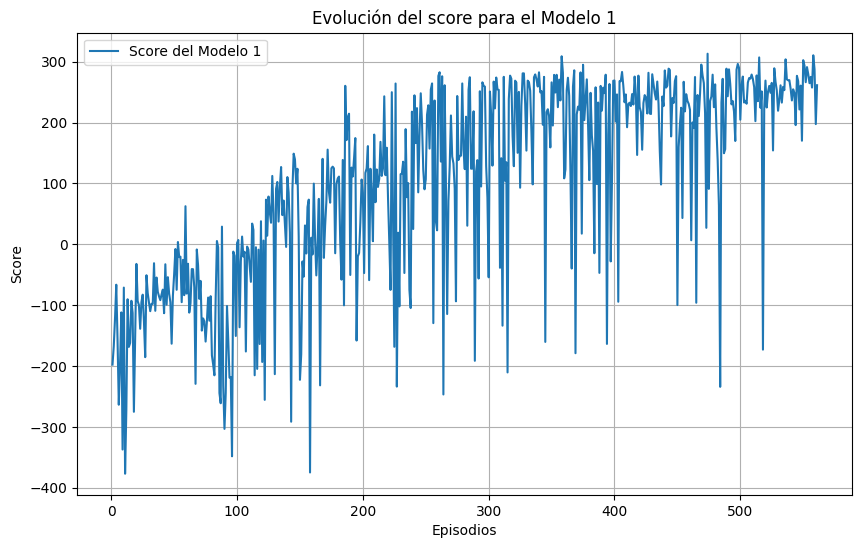

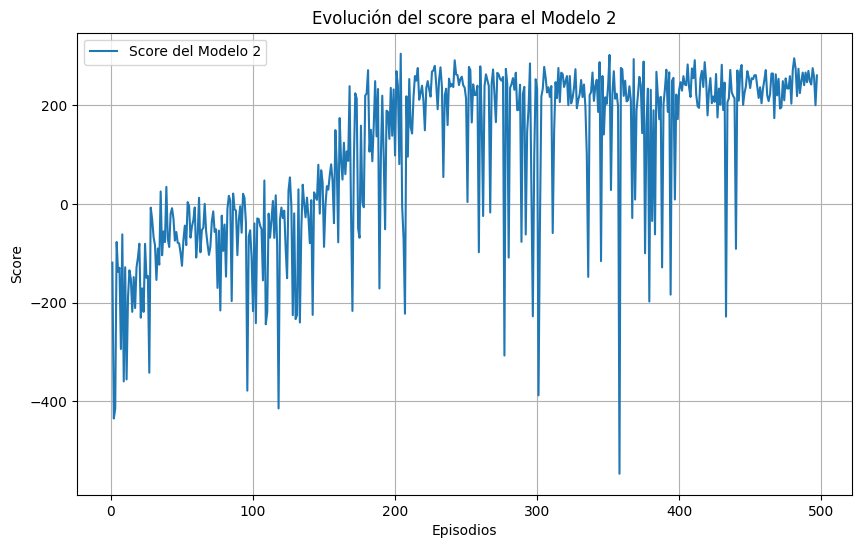

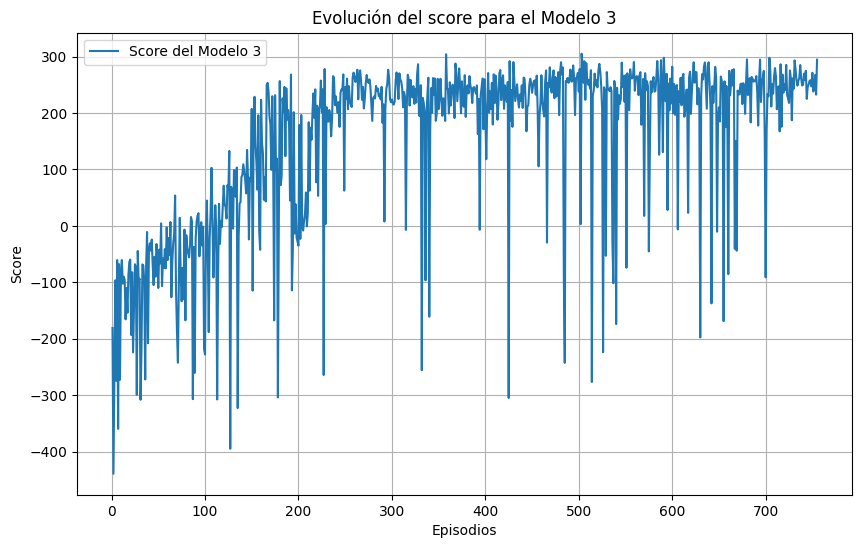

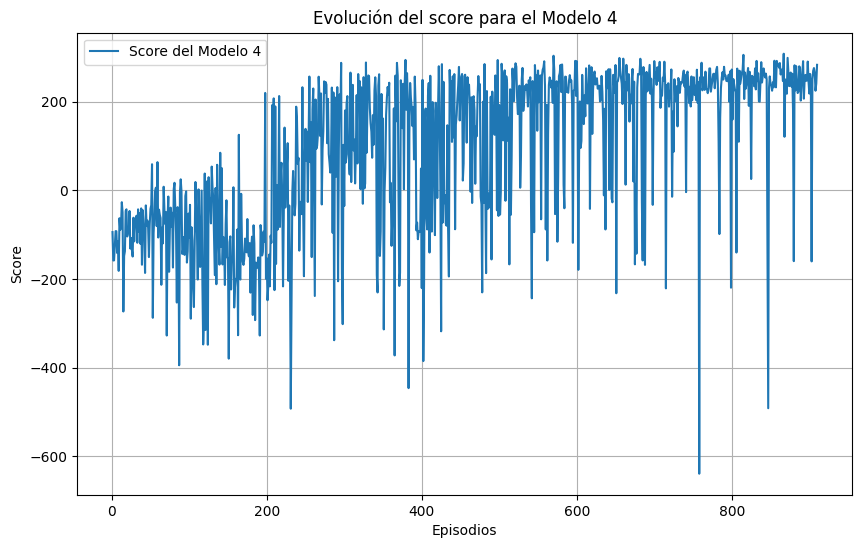

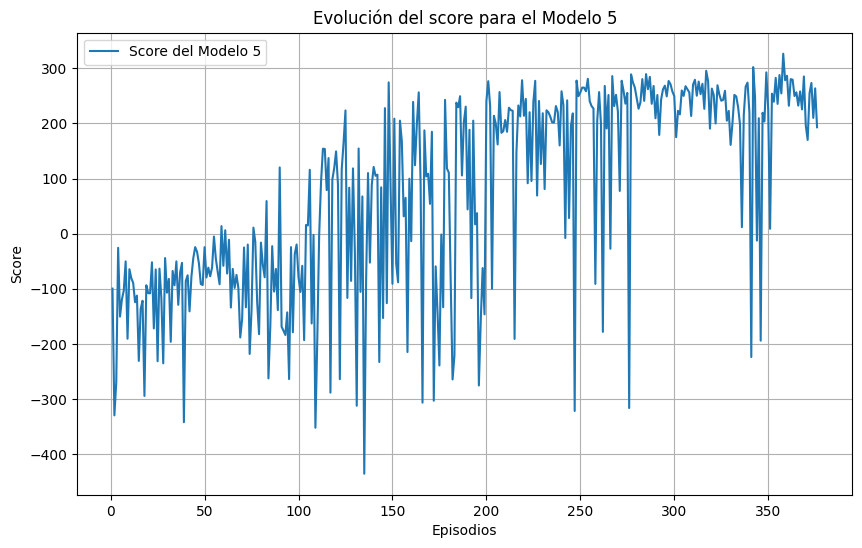

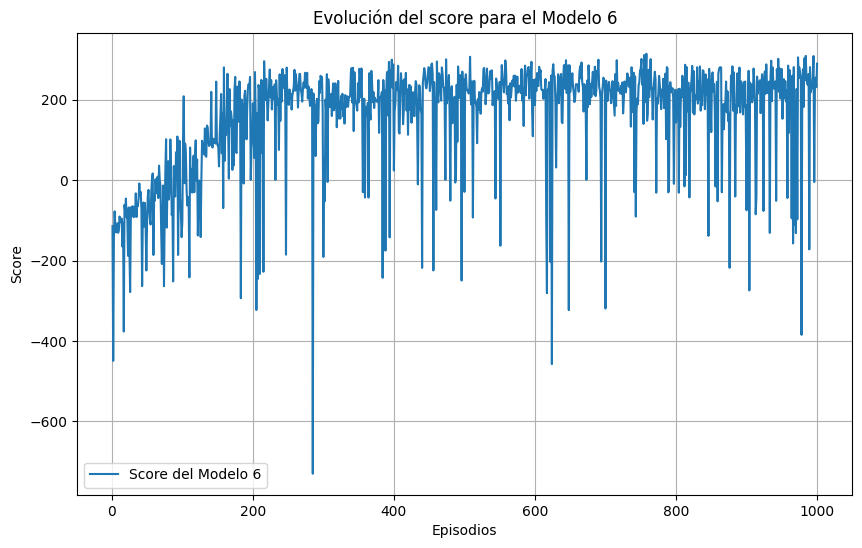

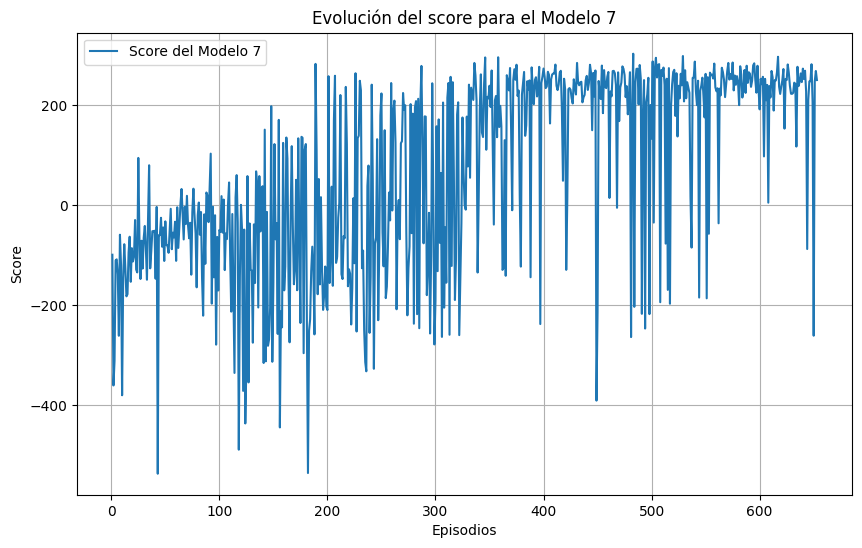

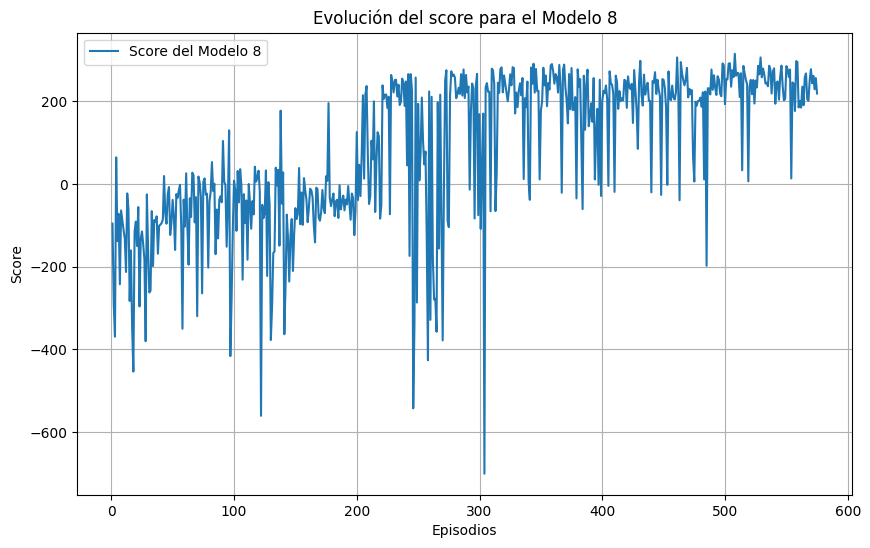

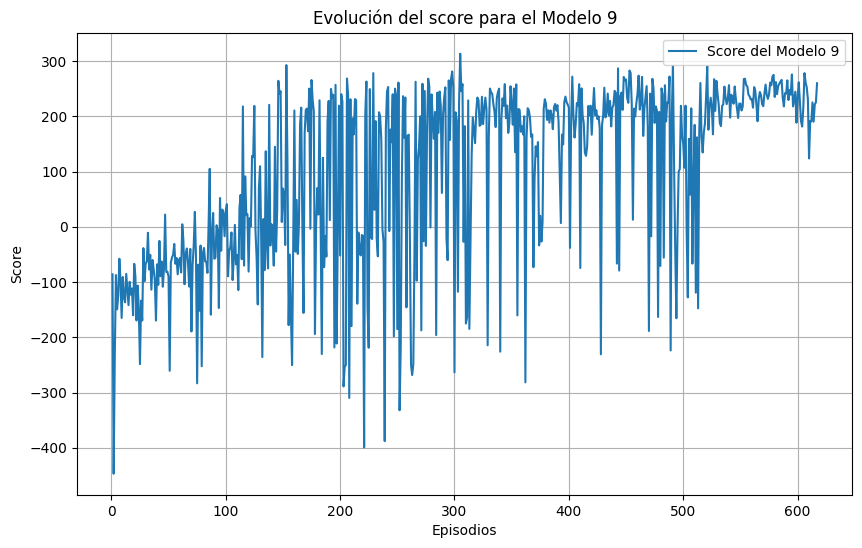

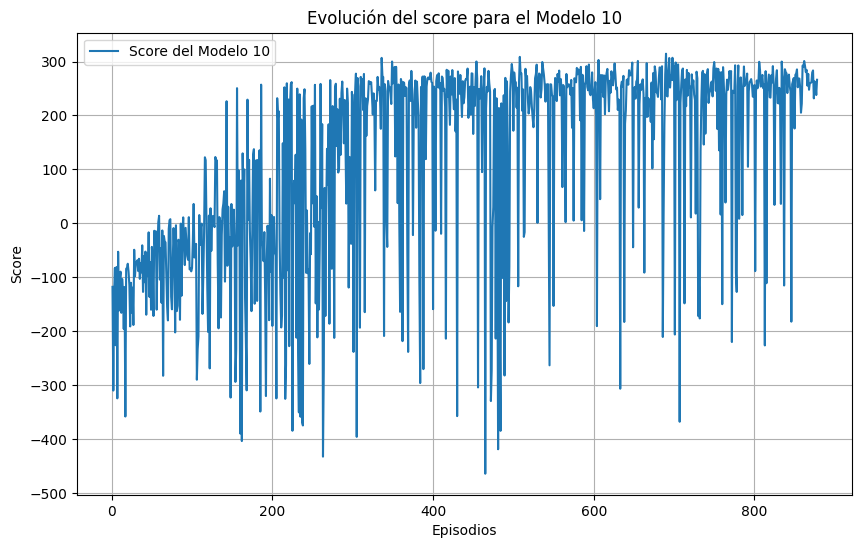

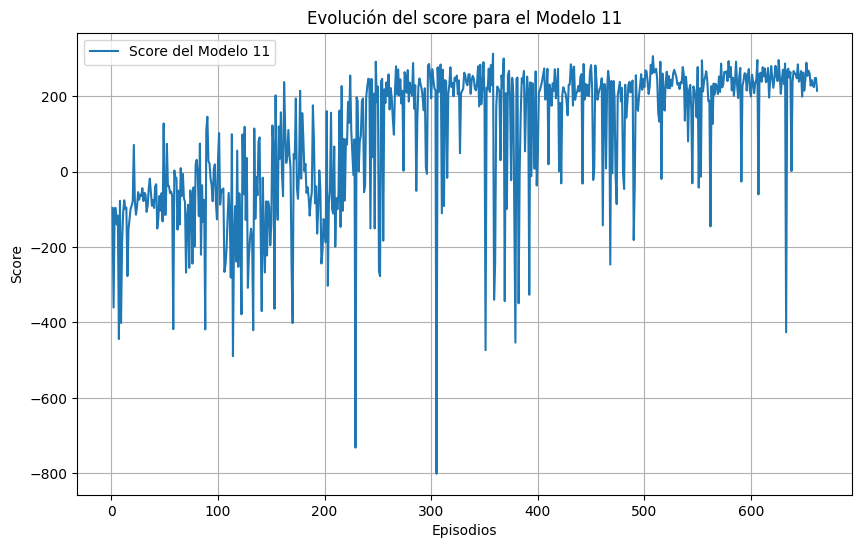

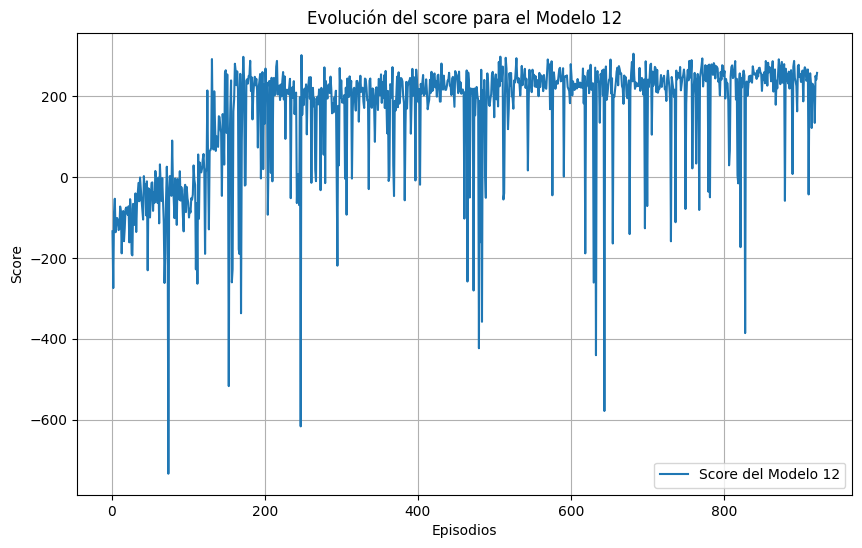


Training times for each model:
Model 1: 15.6 minutes
Model 2: 11.12 minutes
Model 3: 15.0 minutes
Model 4: 19.28 minutes
Model 5: 8.19 minutes
Model 6: 19.2 minutes
Model 7: 13.66 minutes
Model 8: 14.13 minutes
Model 9: 15.09 minutes
Model 10: 18.48 minutes
Model 11: 16.03 minutes
Model 12: 19.58 minutes

Average scores for each model:
Model 1: 101.4
Model 2: 101.46
Model 3: 153.38
Model 4: 91.58
Model 5: 75.0
Model 6: 155.88
Model 7: 68.93
Model 8: 86.2
Model 9: 95.92
Model 10: 118.09
Model 11: 96.42
Model 12: 157.34


In [17]:
for i, (episodios, scores) in enumerate(resultados):
    plt.figure(figsize=(10, 6))  # Crea una nueva figura para cada modelo
    plt.plot(episodios, scores, label=f'Score del Modelo {i + 1}')
    plt.xlabel('Episodios')
    plt.ylabel('Score')
    plt.title(f'Evolución del score para el Modelo {i + 1}') # Título específico del modelo
    plt.legend() # Añade la leyenda para claridad, aunque solo haya una línea
    plt.grid(True)
    plt.show() # Muestra la figura actual y la cierra para la siguiente iteración
# Print training times using resultados
print("\nTraining times for each model:")
for i, training_time in enumerate(tiempos_entrenamiento):
    print(f"Model {i + 1}: {round(training_time/60, 2)} minutes")
# Print average scores for each model
print("\nAverage scores for each model:")
for i, (episodes, scores) in enumerate(resultados):
    average_score = np.mean(scores)
    print(f"Model {i + 1}: {round(average_score, 2)}")